In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/EVA")

In [4]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils    

from deep_vision.resnet import ResNet
from deep_vision.cutout import get_random_eraser
from deep_vision.lr_finder import LR_Finder 
from deep_vision.clr_callback import CyclicLR

Using TensorFlow backend.


Restrictions:
- Your model must look like Conv->B1->B2->B3->B4 and not individually called Convs. 
- Batch Size 128
- Normalization values of: (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
- Random Crop of 32 with padding of 4px Horizontal Flip (0.5)
- Optimizer: SGD, Weight-Decay: 5e-4
- NOT-OneCycleLR
- Save model (to drive) after every 50 epochs or best model till now
- Describe your blocks, and the stride strategy you have picked
- Train for 300 Epochs
- Assignment Target Accuracy is 90%, so exit gracefully if you reach 90% (you can target more, it can go till ~93%)

In [0]:
BATCH_SIZE = 128 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 300 #@param {type:"integer"}

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

given_mean, given_std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

print("Calc mean:", train_mean)
print("Calc std:", train_std) 

170500096/170498071 [==============================] - 11s 0us/step
Calc mean: [125.30691805 122.95039414 113.86538318]
Calc std: [62.99321928 62.08870764 66.70489964]


In [0]:
# normalize and padding the training data
normalize = lambda x: ((x - given_mean) / given_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train_norm = normalize(x_train)
x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

In [0]:
norm_x_train_mean = np.mean(x_train_norm, axis=(0,1,2))

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [0]:
'''
As we training CIFAR-10, we will be using basic blocks where we are using 
fully pre-activated BN-RELU-CONV(3x3) as  per ResNet V2.  
Resnet.py contains the entire code for building the model
''' 
def make_model():
    return ResNet(input_shape=(32,32,3), classes=10, block='basic', residual_unit='v2',
                  repetitions=[2,2,2,2], initial_filters=64, activation='softmax', include_top=True,
                  input_tensor=None, dropout=None, transition_dilation_rate=(1, 1),
                  initial_strides=(1, 1), initial_kernel_size=(3, 3), initial_pooling=None,
                  final_pooling='avg', top='classification')

#### Finding the min and max learning rates

In [11]:
model = make_model()
sgd = SGD(1e-4, momentum=MOMENTUM, nesterov=True, decay=WEIGHT_DECAY)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])












reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...




In [12]:
lr_finder = LR_Finder(start_lr=1e-7, end_lr=10, step_size=np.ceil(x_train_norm.shape[0]/BATCH_SIZE))
model.fit(x_train_norm, Y_train, callbacks=[lr_finder], batch_size=BATCH_SIZE)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
50000/50000 [==============================] - 25s 501us/step - loss: 3.3897 - acc: 0.1927


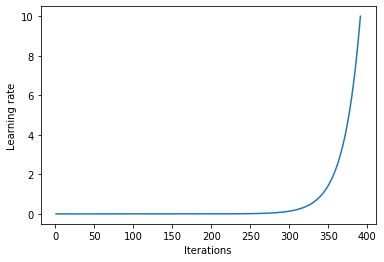

In [13]:
lr_finder.plot_lr()

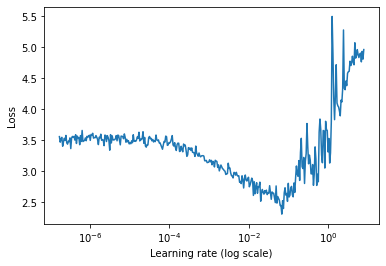

In [14]:
lr_finder.plot_lr_loss()

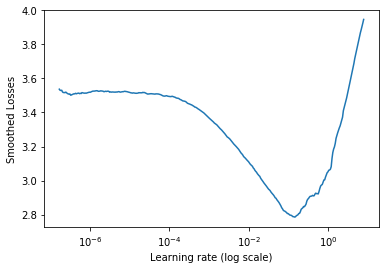

In [15]:
lr_finder.plot_smoothed_lr_loss()

So, from the above plot, we can see that the min and max bounds of learning rate which are 0.0001 and 0.1 respectively

In [0]:
# for random cropping
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

In [0]:
# Define the minimum learning rate, maximum learning rate, batch size, step size, CLR method, and number of epochs
# Triangular2 is the methods where the max learning rate tapers of linearly in each cycle
MIN_LR = 0.0001
MAX_LR = 0.1
STEP_SIZE = 8
CLR_METHOD = "triangular2"
NUM_EPOCHS = 96

### Traininf the mode with cyclic LR

Code for cyclic LR can be found in clr_callback.py

In [19]:
model = make_model()
sgd = SGD(MIN_LR, momentum=MOMENTUM, nesterov=True, decay=WEIGHT_DECAY)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

clr = CyclicLR(mode=CLR_METHOD,
               base_lr=MIN_LR,
               max_lr=MAX_LR,
               step_size= STEP_SIZE * (x_train.shape[0] // BATCH_SIZE))

checkpoint = ModelCheckpoint(filepath="best_model.h5", 
                             save_best_only=True,
                             period=50,
                             monitor="val_loss",
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=0, mode='auto', baseline=90.0, restore_best_weights=True)


reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...


In [20]:
# random_crop = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)

datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(pixel_value=norm_x_train_mean), 
                             horizontal_flip=True)

train_batches = datagen.flow(x_train, Y_train, batch_size=BATCH_SIZE)
train_cropped_batches = crop_generator(train_batches, 32)

model.fit_generator(train_cropped_batches,
                    steps_per_epoch=x_train.shape[0]//BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data=(x_test, Y_test), 
                    callbacks=[clr, checkpoint, earlystop],
                    verbose=1)

Epoch 1/300
390/390 [==============================] - 27s 70ms/step - loss: 2.7379 - acc: 0.3523 - val_loss: 2.5363 - val_acc: 0.4337
Epoch 2/300
  3/390 [..............................] - ETA: 21s - loss: 2.5277 - acc: 0.4365

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


390/390 [==============================] - 24s 63ms/step - loss: 2.2942 - acc: 0.5156 - val_loss: 2.1437 - val_acc: 0.5712
Epoch 3/300
390/390 [==============================] - 25s 63ms/step - loss: 2.0713 - acc: 0.5939 - val_loss: 2.1959 - val_acc: 0.5569
Epoch 4/300
390/390 [==============================] - 24s 61ms/step - loss: 1.9094 - acc: 0.6453 - val_loss: 2.0879 - val_acc: 0.6107
Epoch 5/300
390/390 [==============================] - 24s 62ms/step - loss: 1.7752 - acc: 0.6825 - val_loss: 2.5292 - val_acc: 0.5425
Epoch 6/300
390/390 [==============================] - 25s 64ms/step - loss: 1.6690 - acc: 0.7158 - val_loss: 1.7069 - val_acc: 0.7002
Epoch 7/300
390/390 [==============================] - 24s 62ms/step - loss: 1.5755 - acc: 0.7378 - val_loss: 2.1579 - val_acc: 0.5855
Epoch 8/300
390/390 [==============================] - 24s 60ms/step - loss: 1.4944 - acc: 0.7539 - val_loss: 2.1184 - val_acc: 0.6065
Epoch 9/300
390/390 [==============================] - 24s 62ms/ste

We can see that model reached 90% accuracy quite early, however, it didn't go much above than that.  